# `pspd` in the wild

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

## Input data

First, let's read and visualize the point cloud that contains the coordinates of the surface.

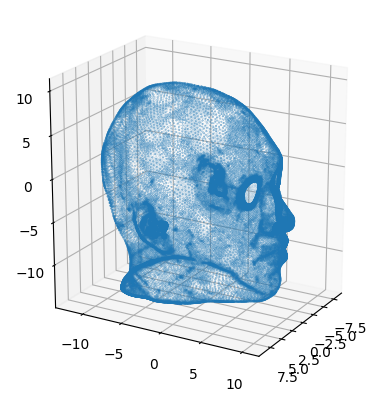

In [2]:
fname = os.path.join('input', 'data', 'head.scaled')  # in centimeters
points = np.loadtxt(fname + '.xyz')

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(*points.T, s=0.05)
ax.set_box_aspect(np.ptp(points, axis=0))
ax.view_init(20, 30)
plt.show()

Now, let's generate the power density in a Gaussian pattern over the entire surface with the "hot-spot" located on the upper crus of the right outer ear. The function is already defined in `single_source` file. It requires the *amplitude* of the incident power density at the centre of the irradiated region in watts per meter squared, *radius* of a circular area representing the irradiated region (unit should correspond the unit of the point cloud, in this case, it should be given in centimeters), *center point* of the irradiated region (again, the unit should correspond the unit of the point cloud, in this case, it should be given in centimeters) and the scaler that stretches the distance between the centre point and remaining points of the irradiated region component-wise (dimensionless quantity).

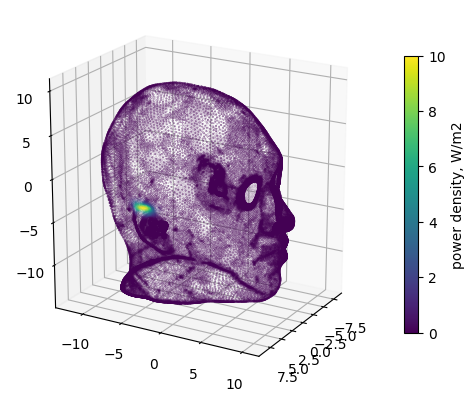

In [3]:
from single_source import generate_power_density


power_density = generate_power_density(
    amplitude=10,  # W/m2
    radius=2.5,  # cm
    query_point=np.array([8.4082, -3.0716, -1.8224]),  # cm
    points=points,  # cm
    scaler=[1, 0.5, 0.25]
)

fig = plt.figure()
ax = plt.axes(projection='3d')
s = ax.scatter(*points.T, s=0.05, c=power_density)
cbar = fig.colorbar(s, ax=ax, shrink=0.75, label='power density, W/m2')
ax.set_box_aspect(np.ptp(points, axis=0))
ax.view_init(20, 30)
plt.show()

## Detection of the peak spatial-average power density

### Point cloud

In the simplest implementation, the algorithm requires only a 3-D point cloud sampled on the surface of the model along with the corresponding power density values at each of the points. Additionally, the area of the square projection of the evaluation surface has to be defined in order to find the peak spatially averaged power density on the surface.

In [4]:
from pspd import PSPD

pspd = PSPD(points, power_density)
pspd.find(projected_area=4)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
INFO:root:Unrecognized mesh; proceeding without it...
INFO:root:Estimating normals with k-nn = 22...
INFO:root:Execution started at 2023-07-28 20:18:45.699748
INFO:root:Execution finished at 2023-07-28 20:19:05.500526
INFO:root:Elapsed time: 19.8003 s
INFO:root:Execution started at 2023-07-28 20:19:05.523593


  0%|          | 0/63333 [00:00<?, ?it/s]

INFO:root:Execution finished at 2023-07-28 20:20:51.029663
INFO:root:Elapsed time: 105.5054 s


Since no mesh has been provided, in order to estimate the conformal surface, which corresponds to the projected averaging area mapped on the surface of the human head model, surface normals are estimated. This way, the area of the evaluation surface is estimated as the surface integral of normals' magnitude.

The results can be extracted in dictionary. From there, it is straightforward to check the peak spatially averaged power density. Note, the current implementation estimates the spatially averaged power density by integrating the Poynting vector on the surface. The implentation of the defintion for the surface-normal propagation-direction power density into the evaluation surface is directly taken from IEC/IEEE 63195 Standard.

In [5]:
res = pspd.get_results()

In [6]:
res['spatially averaged power density']

4.67646452743277

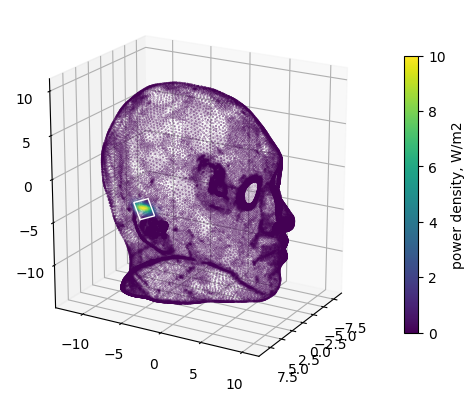

In [7]:
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d.art3d import pathpatch_2d_to_3d


# extract relevant data from the output
p = res['query point']
nbh = res['k-neigborhood']
area = res['surface area']
pspd = res['spatially averaged power density']

# compute the angle of rotation for matplotlib's square patch
idx_at_ymin = np.argmin(nbh[:, 1])
ymin = nbh[idx_at_ymin, 1]
z_at_ymin = nbh[idx_at_ymin, 2]

idx_at_zmin = np.argmin(nbh[:, 2])
zmin = nbh[idx_at_zmin, 2]
y_at_zmin = nbh[idx_at_zmin, 1]

d = z_at_ymin - zmin
r = np.sqrt(np.sqrt(area))
angle_rad = 2 * np.arcsin(d / (2 * r))
angle = np.rad2deg(angle_rad)

# search space
fig = plt.figure()
ax = plt.axes(projection='3d')
s = ax.scatter(*points.T, s=0.05, c=power_density)
cbar = fig.colorbar(s, ax=ax, shrink=0.75, label='power density, W/m2')
square = Rectangle(xy=(ymin, z_at_ymin),
                   width=np.sqrt(area),
                   height=np.sqrt(area),
                   angle=-angle,
                   ec='w', fc='none')
ax.add_patch(square)
pathpatch_2d_to_3d(square, z=p[0], zdir='x')
ax.set_box_aspect(np.ptp(points, axis=0))
ax.view_init(20, 30)
plt.show()

### Triangle mesh

On the other hand, if the triangle mesh has been provided, the conformal surface, which again corresponds to the projected averaging area mapped on the surface of the human head model, is computed by adding area contributions of triangles as specified in IEC/IEEE 63195 Standard.

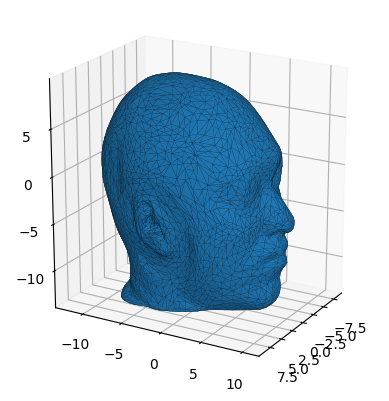

In [8]:
from matplotlib.colors import LightSource
import open3d as o3d


normals = np.loadtxt(fname + '.normals')
mesh = o3d.io.read_triangle_mesh(fname + '.iso.watertight.off')
mesh_smp = mesh.simplify_quadric_decimation(6500)
vert_smp = np.asarray(mesh_smp.vertices)
tri_smp = np.asarray(mesh_smp.triangles)
ls = LightSource(40, 30)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_trisurf(*vert_smp.T, triangles=tri_smp, ec='k', lw=0.05, lightsource=ls)
ax.set_box_aspect(np.ptp(points, axis=0))
ax.view_init(20, 30)
plt.show()

In [9]:
pspd = PSPD(points, power_density, normals=normals, mesh=mesh)
pspd.find(projected_area=4)

INFO:root:Execution started at 2023-07-28 20:20:54.610637


  0%|          | 0/63333 [00:00<?, ?it/s]

INFO:root:Execution finished at 2023-07-28 20:24:55.381624
INFO:root:Elapsed time: 240.7698 s


In [10]:
res = pspd.get_results()

In [11]:
res['spatially averaged power density']

4.45096085777223

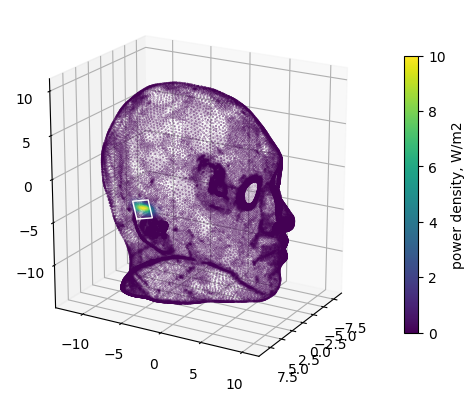

In [12]:
# extract relevant data from the output
p = res['query point']
nbh = res['k-neigborhood']
area = res['surface area']
pspd = res['spatially averaged power density']

# compute the angle of rotation for matplotlib's square patch
idx_at_ymin = np.argmin(nbh[:, 1])
ymin = nbh[idx_at_ymin, 1]
z_at_ymin = nbh[idx_at_ymin, 2]

idx_at_zmin = np.argmin(nbh[:, 2])
zmin = nbh[idx_at_zmin, 2]
y_at_zmin = nbh[idx_at_zmin, 1]

d = z_at_ymin - zmin
r = np.sqrt(np.sqrt(area))
angle_rad = 2 * np.arcsin(d / (2 * r))
angle = np.rad2deg(angle_rad)

# search space
fig = plt.figure()
ax = plt.axes(projection='3d')
s = ax.scatter(*points.T, s=0.05, c=power_density)
cbar = fig.colorbar(s, ax=ax, shrink=0.75, label='power density, W/m2')
square = Rectangle(xy=(ymin, z_at_ymin),
                   width=np.sqrt(area),
                   height=np.sqrt(area),
                   angle=-angle,
                   ec='w', fc='none')
ax.add_patch(square)
pathpatch_2d_to_3d(square, z=p[0], zdir='x')
ax.set_box_aspect(np.ptp(points, axis=0))
ax.view_init(20, 30)
plt.show()

Even though the algorithm was able to find the (more-or-less) same averaging area, there is a substantial difference between the peak spatial-average power density. This is mainly attributable to the way the conformal averaging area (for spatial averaging) is computed. Namely, the surface area estimation via surface integration of normals' magnitude is highly imprecise and dependent on the spatial distribution of normals and the approximation power of the quadrature technique.

## Speed-up

If the incidence of the electromagnetic field is known, the algorithm allows to identify points visible from the predefined direction, which should correspond to the propagation direction of the electromagnetic field.
This step is optional, but it allows to focus solely on a region that is in the line of sight of the sources.
Here, the so-called "hidden point removal" operator, which determines the visible points in a point cloud, as viewed from any given viewpoint is employed.

In [13]:
# define the point-of-view
pov = np.mean(points, axis=0)
diameter = np.linalg.norm(points.ptp(axis=0))
pov[0] += 2 * diameter
pov[1] += 0.5 * diameter

pspd = PSPD(points, power_density, normals=normals, mesh=mesh)
pspd.find(projected_area=4, pov=pov, p=np.pi)

INFO:root:Execution started at 2023-07-28 20:24:56.654470


  0%|          | 0/24995 [00:00<?, ?it/s]

INFO:root:Execution finished at 2023-07-28 20:26:30.023449
INFO:root:Elapsed time: 93.3683 s


The search space is reduced from 63,333 point to 24,995 points, which resulted in a two-fold speed-up with respect to execution time.

In [14]:
res = pspd.get_results()

In [15]:
res['spatially averaged power density']

4.45096085777223

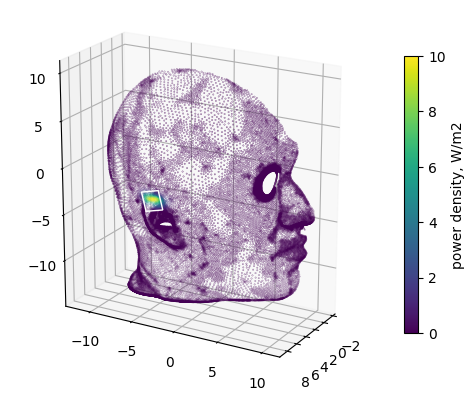

In [16]:
# extract relevant data from the output
ind, _ = pspd.get_points()
res = pspd.get_results()

# compute the angle of rotation for matplotlib's square patch
idx_at_ymin = np.argmin(nbh[:, 1])
ymin = nbh[idx_at_ymin, 1]
z_at_ymin = nbh[idx_at_ymin, 2]

idx_at_zmin = np.argmin(nbh[:, 2])
zmin = nbh[idx_at_zmin, 2]
y_at_zmin = nbh[idx_at_zmin, 1]

d = z_at_ymin - zmin
r = np.sqrt(np.sqrt(area))
angle_rad = 2 * np.arcsin(d / (2 * r))
angle = np.rad2deg(angle_rad)

# search space
fig = plt.figure()
ax = plt.axes(projection='3d')
s = ax.scatter(*points[ind].T, s=0.05, c=power_density[ind])
cbar = fig.colorbar(s, ax=ax, shrink=0.75, label='power density, W/m2')
square = Rectangle(xy=(ymin, z_at_ymin),
                   width=np.sqrt(area),
                   height=np.sqrt(area),
                   angle=-angle,
                   ec='w', fc='none')
ax.add_patch(square)
pathpatch_2d_to_3d(square, z=p[0], zdir='x')
ax.set_box_aspect(np.ptp(points[ind], axis=0))
ax.view_init(20, 30)
plt.show()